# Assignment 16: Phát hiện và bám vết chuyển động với phương pháp trừ nền và Kalman Filter

Trong bài tập này chúng ta sẽ thực hành phát hiện các đối tượng chuyển động (mà cụ thể trong bài thực hành này là người) sử dụng phương pháp trừ nền (Background subtraction) và bám vết các đối tượng này với bộ lọc Kalman (Kalman filter). Vì ta sẽ thao tác với video và các đoạn code khá phức tạp nên các đoạn code sẽ không được đưa trực tiếp vào notebook này mà để dưới dạng các file source code .py cùng thư mục với bài thực hành.

In [1]:
import numpy as np
import imutils
import cv2
import os
import matplotlib.pyplot as plt

## Phần 1: Phát hiện chuyển động

Đầu tiên ta sẽ thực hành phát hiện chuyển động với mô hình trừ nền Gaussian Mixture Model. Mô hình này ta được cài đặt sẵn trong thư viện OpenCV. Quan sát file source code part1_1.py, trong file này ta sẽ đọc video dữ liệu, sau đó sử dụng Gaussian Mixture Model để phát hiện đối tượng chuyển động trong video. Hãy quan sát kết quả sau:

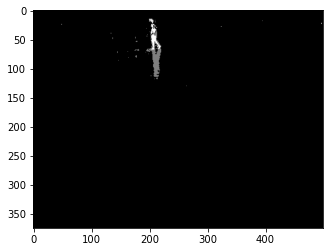

In [2]:
img = cv2.imread('gmm.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY);
plt.imshow(img, cmap='gray')
plt.show()

Trong kết quả trên và cả trong thực tế, khi áp dụng GMM ta hay thu được kết quả có nhiễu hạt, để khử những nhiễu hạt này ta có thể sử dụng Median filter đã được cài đặt sẵn trong OpenCV:

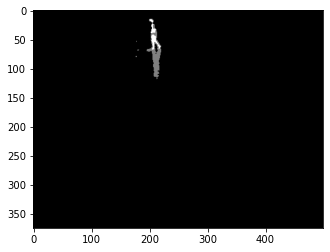

In [3]:
img = cv2.medianBlur(img, 3)
plt.imshow(img, cmap='gray')
plt.show()

Tiếp theo, ta sử dụng phép biến đổi dilate để nối các block cùng màu lại với nhau:

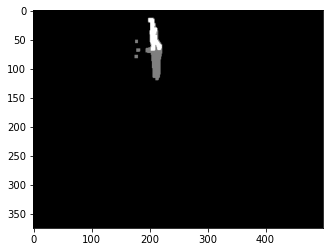

In [4]:
dilate = cv2.dilate(img, None, iterations=2)
plt.imshow(dilate, cmap='gray')
plt.show()

Trong mô hình GMM được cài đặt trong OpenCV, đối tượng chuyển động sẽ được biểu diễn bằng các pixel trắng, bóng (shadow) của đối tượng được biểu diễn bằng các pixel màu xám hơn. Ta sẽ thực hiện một bước biến đổi đơn giản để loại bỏ bóng:

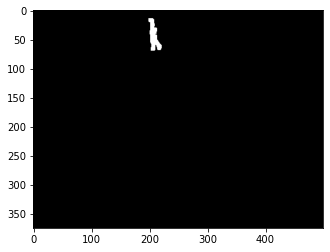

In [5]:
_, dilate = cv2.threshold(dilate, 127, 255, cv2.THRESH_BINARY)
plt.imshow(dilate, cmap='gray')
plt.show()

Tiếp theo, dùng hàm findContours của OpenCV để tìm các vật thể trong khung hình:

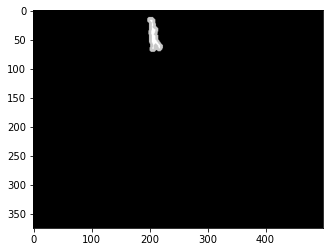

In [6]:
im2, contours, hierarchy = cv2.findContours(dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts_image = cv2.drawContours(dilate, contours, -1, (200), 3)
plt.imshow(cnts_image, cmap='gray')
plt.show()

Cuối cùng, ta sẽ vẽ một bounding box hình chữ nhật để bao quanh vật thể, OpenCV hỗ trợ hàm boundingRect để làm việc này, kết quả thu được như sau:

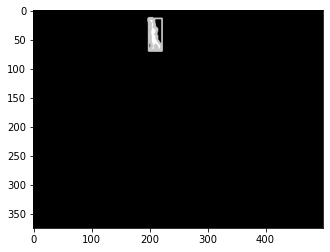

In [7]:
(x, y, w, h) = cv2.boundingRect(contours[0])

cv2.rectangle(cnts_image, (x, y), (x + w, y + h), (200), 2)
plt.imshow(cnts_image, cmap='gray')
plt.show()

Ngoài ra, trong nhiều trường hợp, ta có thể tìm thấy nhiều vật thể khác nhau bằng phương pháp này. Lúc đó ta cần có những biện pháp khác nhau để loại bỏ những vật thể không mong muốn. Trong bài toán ta đang khảo sát, mỗi khung hình ta chỉ giữ lại vật thể mà bounding box của nó có diện tích lớn nhất, và diện tích này phải lớn hơn một ngưỡng cho trước nào đó. Tổng kết lại tất cả các vấn đề trên, ta thu được đoạn mã nguồn để phát hiện đối tượng: part1_2.py

## Phần 2: Bám vết vật thể với Kalman filter 

Tiếp theo, ta sẽ bám vết vật thể với bộ lọc Kalman. OpenCV cũng đã hỗ trợ bộ lọc này, ta cần hiểu rõ các tham số của bộ lọc. Hàm sau đây hỗ trợ ta khởi tạo một đối tượng Kalman filter:

In [8]:
def create_kalman():
    dt = 0.2
    kalman = cv2.KalmanFilter(4, 2, 0)
    kalman.transitionMatrix = np.array(
        [[1., 0., dt, 0.], [0., 1., 0., dt], [0., 0., 1., 0.], [0., 0., 0., 1.]], dtype=np.float32)
    kalman.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], dtype=np.float32)
    kalman.processNoiseCov = 0.5 * np.array([[dt ** 4.0 / 4.0, 0., dt ** 3.0 / 2.0, 0.],
                                             [0., dt ** 4.0 / 4.0, 0., dt ** 3.0 / 2.0],
                                             [dt ** 3.0 / 2.0, 0., dt ** 2.0, 0.],
                                             [0., dt ** 3.0 / 2.0, 0., dt ** 2.0]], dtype=np.float32)
    kalman.measurementNoiseCov = 1e-1 * np.eye(2, dtype=np.float32)
    kalman.errorCovPost = 1e-1 * np.eye(4, dtype=np.float32)

    return kalman

Do ta cần thao tác với video nên phần này chúng ta sẽ thực hành trực tiếp trên file mã nguồn. Hãy cùng quan sát và hoàn chỉnh file part2.py

# BÀI TẬP VỀ NHÀ

Sử dụng mô hình coconut detection đã thực hành ở Bài 14, kết hợp với thuật toán Kalman filter, hãy xây dựng thuật toán đếm số dừa trên băng chuyền trên video tại link sau: https://husteduvn-my.sharepoint.com/:v:/g/personal/cuong_ltb140542_sis_hust_edu_vn/EZxB_icbI-VJkci_Yt80yugBrjDKswPx5KcJ3AluLJ3Yyw?e=o4DeBB